In [33]:
import numpy as np
from control import matlab
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd

# 演習問題
## 11.1

In [10]:
A = np.array([[0, 1],[0, 2]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])

- 拡大系の可制御性を判別する

In [4]:
Uc_bar = np.block([[A, B], [C, np.zeros((1,1))]])
Rc = np.linalg.matrix_rank(Uc_bar)

In [8]:
display(Uc_bar)
print("ランク:",Rc,"サイズ:",min(Uc_bar.shape))

array([[0., 1., 0.],
       [0., 2., 1.],
       [1., 0., 0.]])

ランク: 3 サイズ: 3


- ランクがn+m=3なので設計条件を満たしている

## 11.2

- 図11.2のようなサーボ系を構築すると、拡大系は式11.1.9より…

In [234]:
K = 10 #比例ゲイン
A_bar = np.block([[A, np.zeros((A.shape[0], B.shape[1]))],[-C, np.zeros((C.shape[0], C.shape[0]))]])
B_bar = np.block([[B],[np.zeros((C.shape[0], B.shape[1]))]])
F_bar = np.block([F, -K])

C_bar = np.block([C, np.zeros((C.shape[0], C.shape[0]))])

[0. 0. 2.]


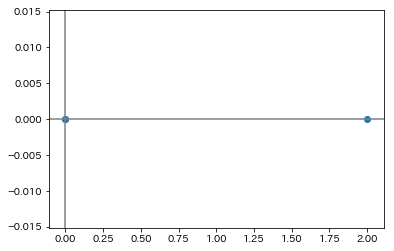

In [235]:
# 拡大系の固有値を確認
plt.figure()
print(np.linalg.eig(A_bar)[0])
plt.scatter(np.real(np.linalg.eigvals(A_bar)), np.imag(np.linalg.eigvals(A_bar)))
plt.axhline(0,-120,5,color="gray")
plt.axvline(0,-20,20,color="gray")
plt.show()

- 極配置法で極を移動

In [241]:
pole = [-1, -1, -3] #配置したい極の位置
F_bar = matlab.acker(A_bar, B_bar, pole)
F_bar

matrix([[ 7.,  7., -3.]])

## 11.3

### 注意
- 式(11.1.11)に拡大系の入力行列B（単位行列）が実は隠れている
    - $\dot{\bar{x}} = (\bar{A}-\bar{B}\bar{F})\bar{x} + I\left(
    \begin{array}{c}
      v  \\
      r
    \end{array}
  \right)$って感じになってる
        - のでこれをlsim関数に渡してあげなければいけない

In [237]:
Td = np.arange(0, 50, 0.01) #シミュレーション時間0~50s,0.01s刻み

v1 = 1*(Td>0) #ステップ状外乱
v2 = 2*(Td>0) 
r  = 3*(Td>0) #ステップ状入力

Ud = np.block([[v1], [v2], [r]]).T

X0 = [1.0, 1.0, 0.0] # 初期状態量
sys = matlab.ss(A_bar-np.dot(B_bar,F_bar), np.eye(3), C_bar, 0)
y, tt, x = matlab.lsim(sys, Ud, Td, X0) #線形システムシミュレータ

In [238]:
df = pd.concat((pd.DataFrame(tt), pd.DataFrame(y) ,pd.DataFrame(np.dot(x, -F_bar.T)), pd.DataFrame(x)), axis = 1) #u =-Fx 

In [239]:
df.columns = ["t", "y", "u", "x1", "x2", "z" ]

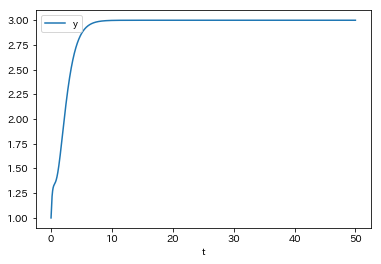

In [240]:
df.plot(x="t", y="y")

- 外乱が入っても偏差なく入力を追従している

## 積分器がないただの状態フィードバックの場合

In [212]:
r = 2
v = np.zeros((A.shape[0], 1))

Td = np.arange(0, 50, 0.01) #シミュレーション時間0~50s,0.01s刻み
Ud = r*(Td>0) #入力信号（ステップ入力）

X0 = [1]*2 # 初期状態量
sys = matlab.ss(A-np.dot(B,F), B, C, 0)
y, tt, x = matlab.lsim(sys, Ud, Td, X0) #線形システムシミュレータ

In [213]:
df = pd.concat((pd.DataFrame(tt), pd.DataFrame(y) ,pd.DataFrame(np.dot(x, -F.T))), axis = 1) #u =-Fx 

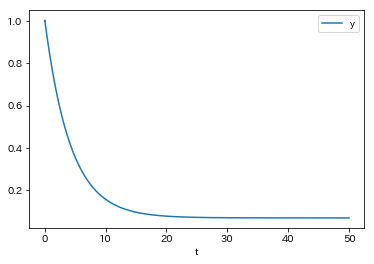

In [214]:
df.columns = ["t", "y", "u" ]
df.plot(x="t", y="y")

- 定常偏差が残る